#  Importação de Bibliotecas para o Projeto

##  Análise exploratória e manipulação de dados

In [53]:
import pandas as pd
import numpy as np
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from sklearn.decomposition import PCA

## Modelos utilizados

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

## Técnicas de seleção de modelos

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


## Pré-processamento de dados

In [56]:
from sklearn.preprocessing import StandardScaler

## Métricas de avaliação dos modelos

In [57]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

#  Realizando a extração e validação dos dados

In [58]:
#  Realizando o download do arquivo iris.csv e já colocando em um dataframe

df = pd.read_csv(
    "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
)

df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


## Valores Vazios

Como podemos ver abaixo, não há valores vazios no dataset.

In [59]:
(
    df
    .isnull()
    .sum()
)

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64

## Convertendo o tipo da coluna `variety` para categórica

Como podemos observar nas informações do dataset, a coluna `variety` está como `object`, ou seja, como uma string. Para que possamos realizar a análise de maneira mais correta, precisamos converter essa coluna para o tipo categórico.


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [61]:
df = (
    df
    .astype({
        'variety' : 'category'
    })
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal.length  150 non-null    float64 
 1   sepal.width   150 non-null    float64 
 2   petal.length  150 non-null    float64 
 3   petal.width   150 non-null    float64 
 4   variety       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


# Análise Exploratória de Dados

## Verificando a distribuição das categorias

Caso as categorias não estejam balanceadas, pode ser necessário realizar alguma técnica de balanceamento, já que o modelo pode acabar tendo um viés para uma categoria. No entato, como podemos ver abaixo, as categorias estão balanceadas.

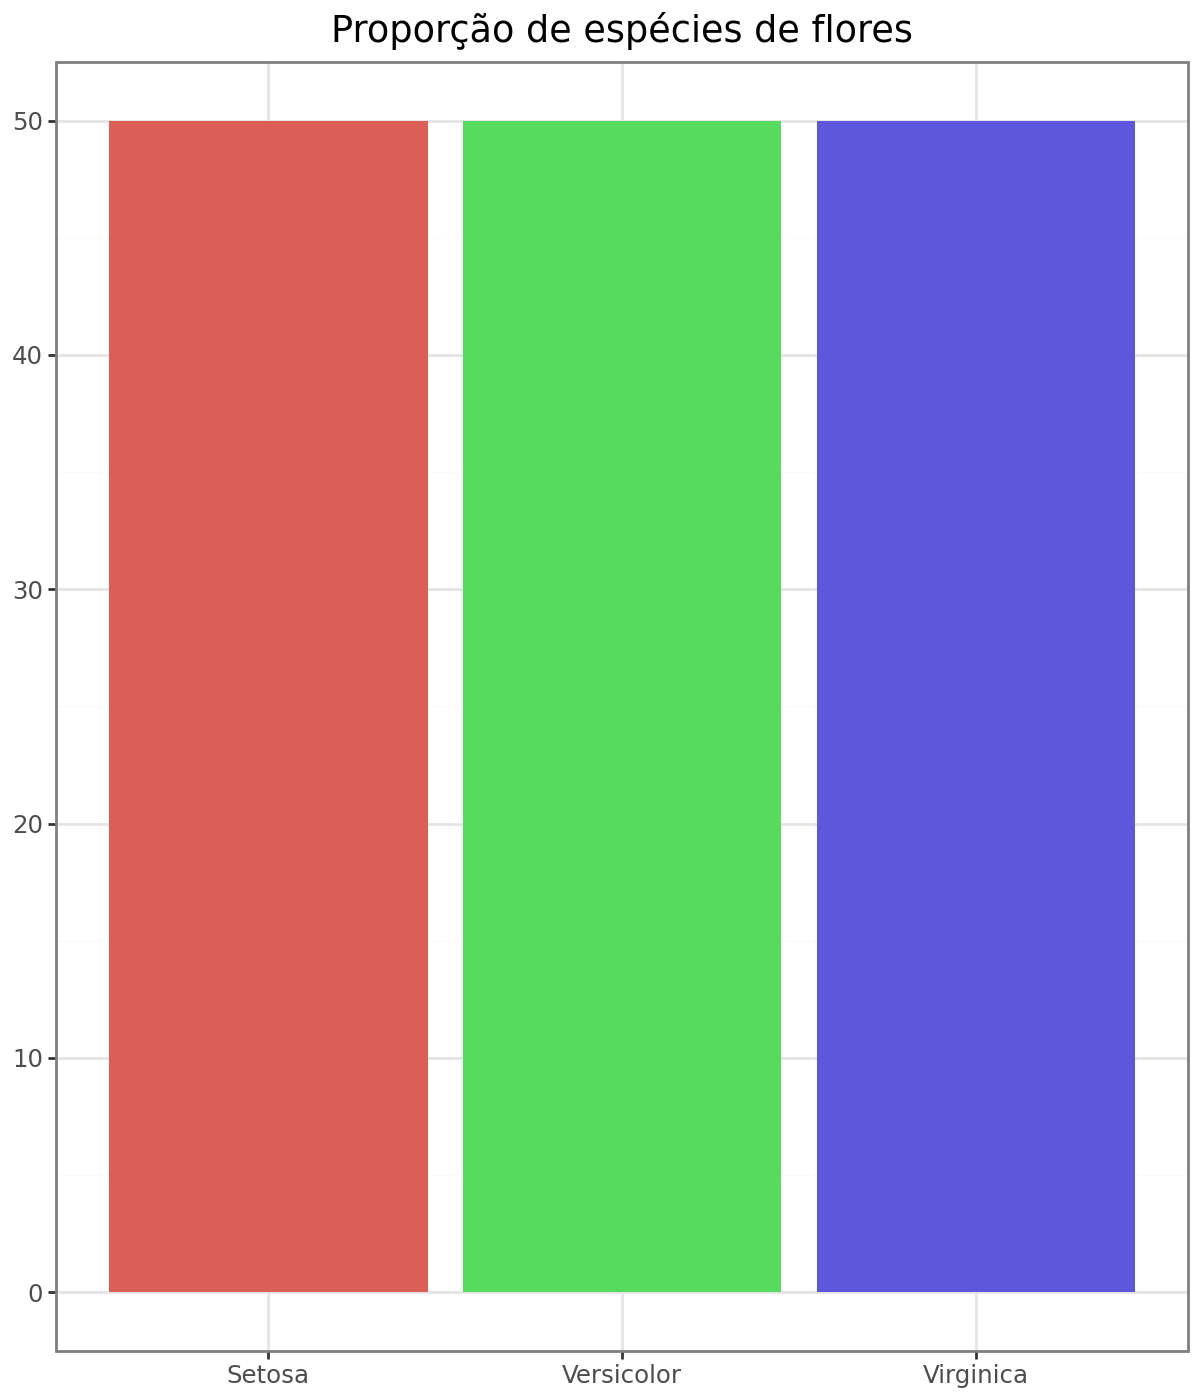

In [62]:
(
    df
    .variety
    .value_counts()
    .reset_index()
    .pipe(
        p9.ggplot
    )
    + p9.aes(
        x = 'variety',
        y = 'count',
        fill = 'variety'
    )
    + p9.geom_col()
    + p9.theme_bw()
    + p9.labs(
        x = 'Espécie',
        y = 'Quantidade',
        title = 'Proporção de espécies de flores',
    )
    + p9.theme(
        legend_position = 'none',
        figure_size=(6, 7),
        plot_title= p9.element_text(hjust = 0.5),
        axis_title=p9.element_blank()
    )
)

## Verificando a distribuição das variáveis numéricas

Como podemos observar no gráfico abaixo, aparentemente não há outliers significantes nas variáveis numéricas e as distribuições aparentam estar bem próximas de uma distribuição normal. Para verificar essa informação, podemos utilizar o teste de Shapiro-Wilk, que é um teste de normalidade onde sua hipótese nula é de que a amostra é proveniente de uma distribuição normal. Observando os p-valores, diferentemente do que imaginei ao observar o gráfico, podemos rejeitar a hipótese nulas para quase todas as variáveis exceto o `petal_length` para as categorias `setosa` e `versicolor`. Dessa forma, vou considerar que as variáveis numéricas não são provenientes de uma distribuição normal.

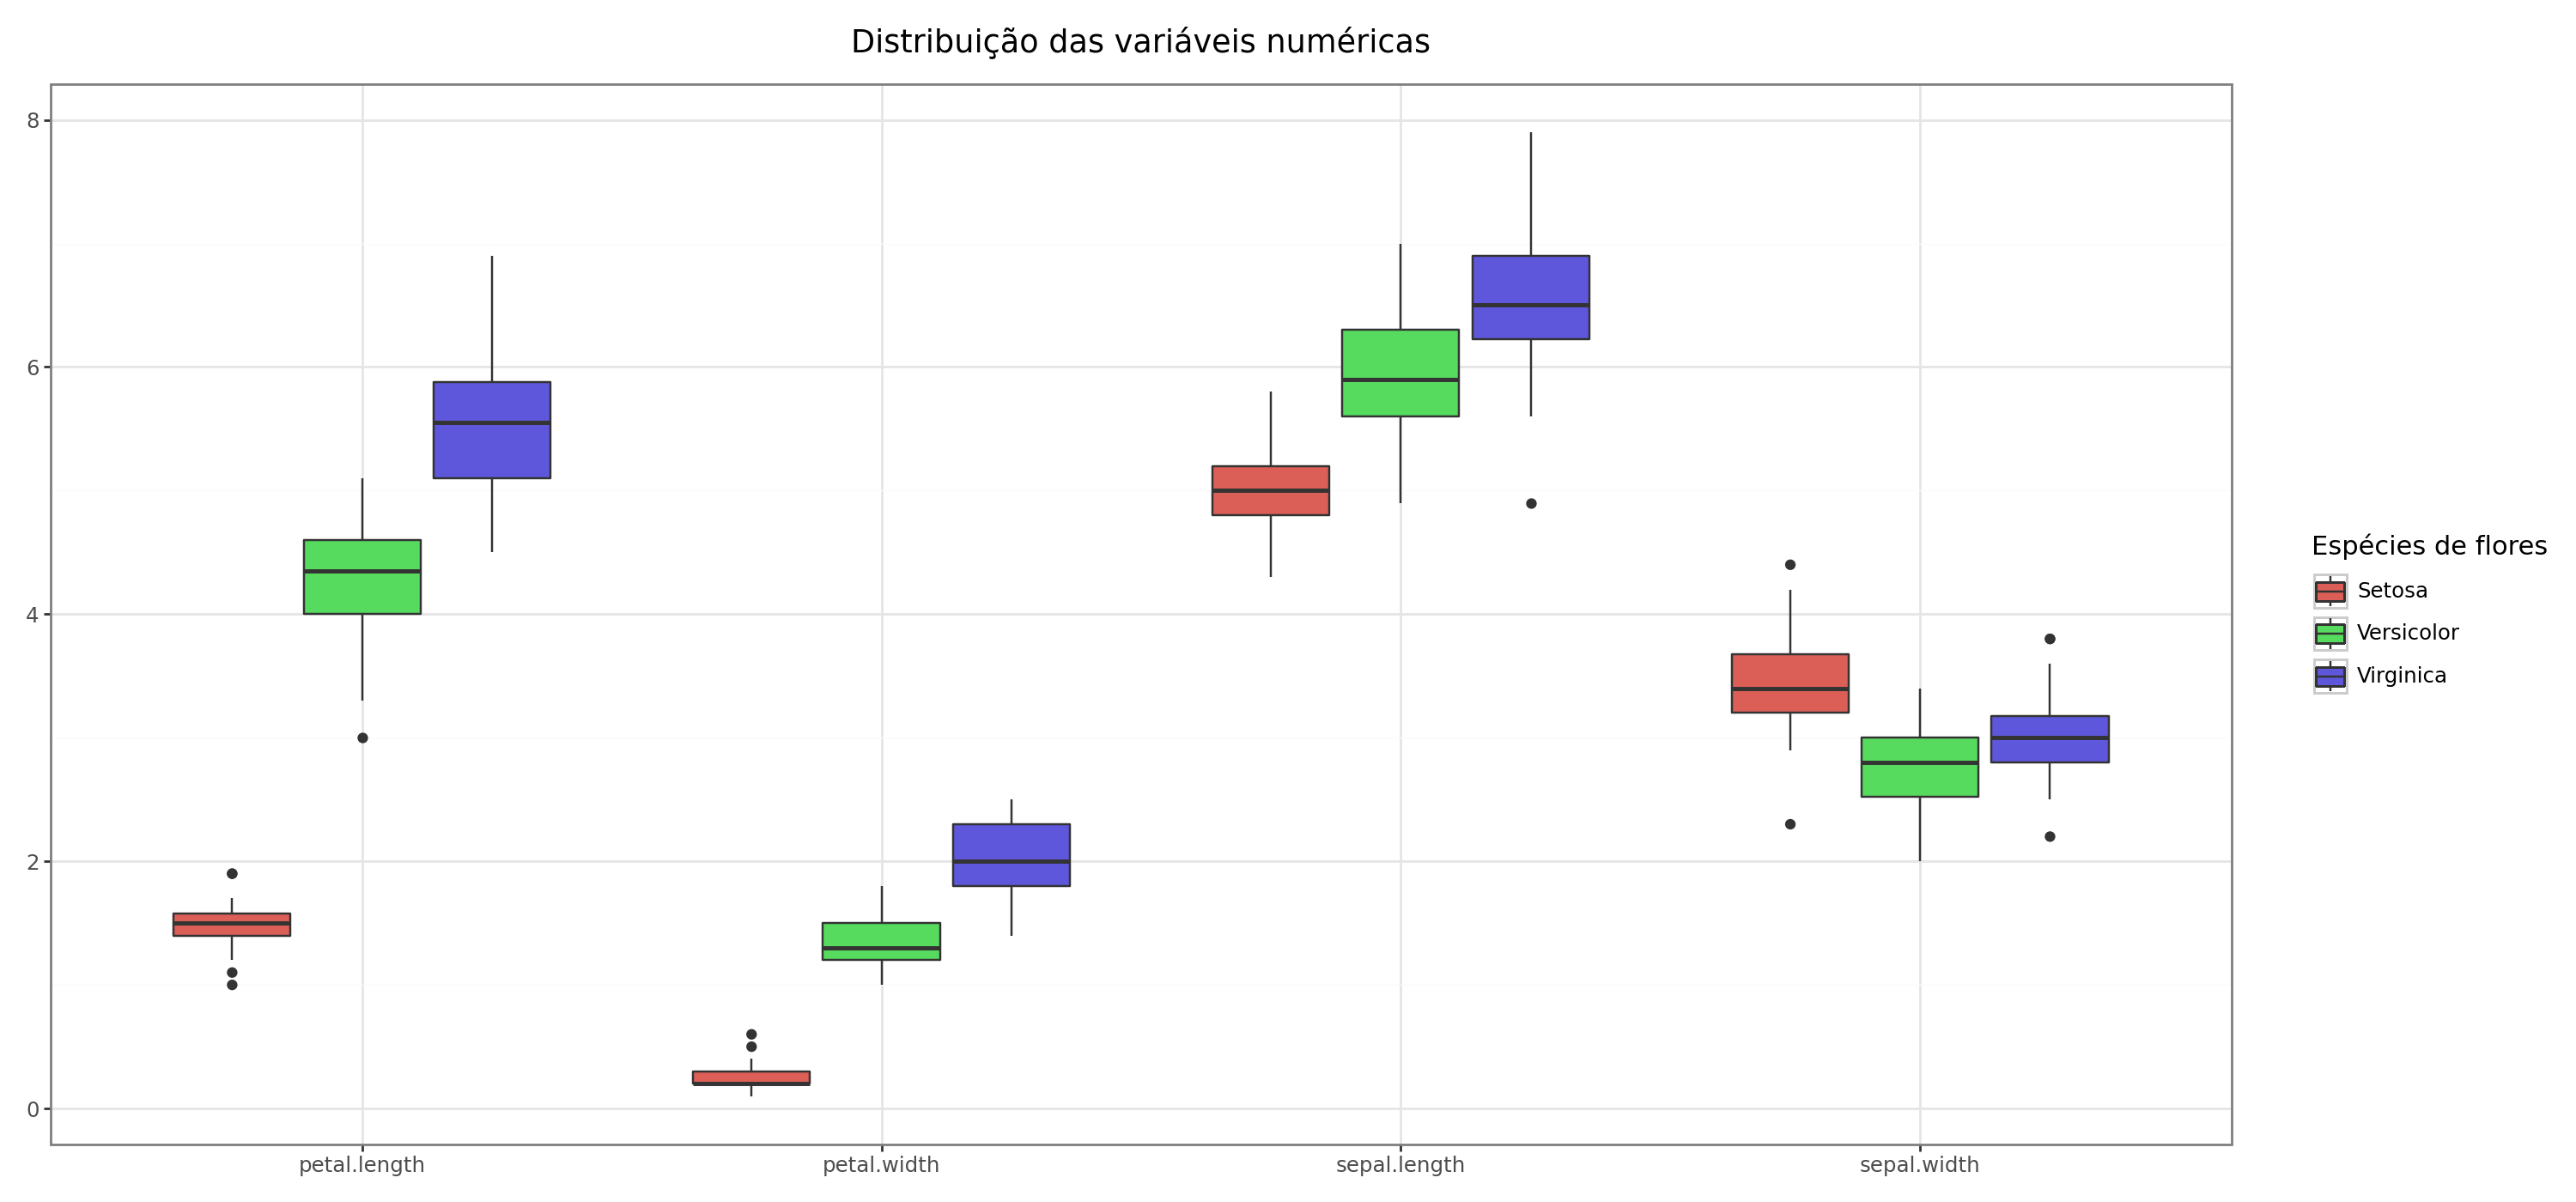

In [63]:
(
    df
    .melt(id_vars = 'variety')
    .pipe(
        p9.ggplot
    )
    + p9.aes(
        x = 'variable',
        y = 'value',
        fill = 'variety'
    )
    + p9.geom_boxplot()
    + p9.theme_bw()
    + p9.labs(
        x = 'Variáveis',
        y = 'Valores',
        title = 'Distribuição das variáveis numéricas',
        fill = 'Espécies de flores'
    )
    + p9.theme(
        plot_title= p9.element_text(hjust = 0.5),
        figure_size=(15, 7),
        axis_title=p9.element_blank(),
    )
)

In [64]:
def shapiro_test_table(df: pd.DataFrame) -> pd.DataFrame:
    df_stats = pd.DataFrame()
    for column in df.columns:
        for specie in df['variety'].unique():
            try:
                #  Verificando se a coluna é numérica
                pd.to_numeric(df[column])
                
                #  Realizando o teste de Shapiro
                statistic, p_value = (
                    df
                    [[column, 'variety']]
                    .query(f'variety == "{specie}"')
                    [column]
                    .pipe(
                        stats.shapiro
                    )
                )
                
                temp_df = pd.DataFrame({
                    'variavel' : [column],
                    'statistic' : [round(statistic, 4)],
                    'p-value' : [round(p_value, 4)],
                    'especie' : [specie]
                })
                df_stats = pd.concat([df_stats, temp_df])
                
                
                
            except ValueError:
                pass
            
        
    df_stats = df_stats.assign(
        reject_h0 = lambda x: x['p-value'] < 0.05
    )
    
    return df_stats

In [65]:
stats_table = shapiro_test_table(df)

stats_table

,variavel,statistic,p-value,especie,reject_h0
0,sepal.length,0.9777,0.4595,Setosa,False
0,sepal.length,0.9778,0.4647,Versicolor,False
0,sepal.length,0.9712,0.2583,Virginica,False
0,sepal.width,0.9717,0.2715,Setosa,False
0,sepal.width,0.9741,0.3380,Versicolor,False
0,sepal.width,0.9674,0.1809,Virginica,False
0,petal.length,0.9550,0.0548,Setosa,False
0,petal.length,0.9660,0.1585,Versicolor,False
0,petal.length,0.9622,0.1098,Virginica,False
0,petal.width,0.7998,0.0000,Setosa,True


In [66]:
stats_table.query('reject_h0 == True')

,variavel,statistic,p-value,especie,reject_h0
0,petal.width,0.7998,0.0000,Setosa,True
0,petal.width,0.9476,0.0273,Versicolor,True


## Análise multivariada

Em vista ao mapa de calor abaixo, podemos concluir que existe uma correlação forte entre as variáveis `petal.length` e `petal.width` e uma correlação moderadamente forte entre as variáveis `sepal.length` e `petal.length`. Nesse contexto, para conseguirmos visualizar melhor o conjunto de dados, podemos utilizar o PCA para reduzir a dimensionalidade do dataset, já que haverá uma pequena perda de informação e conseguirmos visualizar quase toda a informação do dataset em apenas um gráfico. 

Em vista disso, é possível observar em ambas os gráficos de dispersão que as categorias estão bem separadas, em especial a categoria `setosa` que está bem separada das outras duas categorias. Isso me indica que um modelo de classificação provavelmente conseguirá tracar uma fronteira de decisão que separe bem as categorias, isto é, um modelo de classificação provavelmente terá um bom desempenho preditivo.

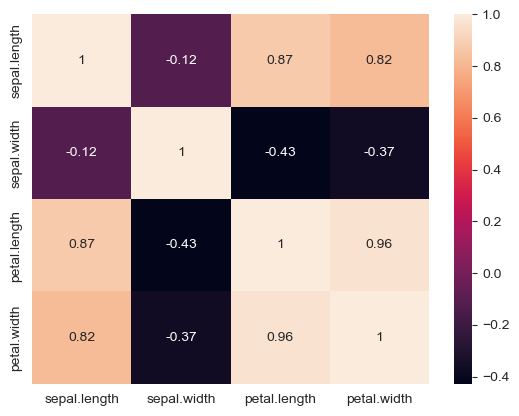

In [67]:
#  Creaintg a heatmap
sns.heatmap(
    df.select_dtypes('number').corr(),
    annot = True,
    
)

plt.show()

In [68]:
def plot_pca_3d_scatter(df: pd.DataFrame, columns: list[str]) -> None:
    pca = PCA(n_components=1)
    pca_df = df.assign(
        pca = pca.fit_transform(df[columns])
    )

    #  Select all coluns but PCA columns
    columns = [column for column in pca_df.columns if column not in columns]
    pca_df = pca_df[columns]    
    
    number_columns = pca_df.select_dtypes('number').columns
    
    fig = px.scatter_3d(
        pca_df,
        x = number_columns[0],
        y = number_columns[1],
        z = number_columns[2],
        color = 'variety',
    )
    
    fig.show()

In [69]:
plot_pca_3d_scatter(df, ['petal.length', 'petal.width'])

In [70]:
plot_pca_3d_scatter(df, ['sepal.length', 'sepal.width'])

# Pré-processamento dos dados

Para o pré-processamento vou apenas normalizar o conjunto de dados utilizando o `StandardScaler` do `sklearn`. 

In [71]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_scale = df.select_dtypes('number').columns
    columns_not_to_scale = [column for column in df.columns if column not in columns_to_scale]
    scaler_object = StandardScaler()
    
    df_scaled = (
        pd.DataFrame(
            scaler_object.fit_transform(df[columns_to_scale]),
            columns = columns_to_scale
        )
        
        .assign(
            **{
                column : df[column]
                for column in columns_not_to_scale
            }
        )
    )    
    
    return df_scaled


def create_modeling_data() -> pd.DataFrame:
    return (
        pd.read_csv(
            "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
        )
        .pipe(normalize)
    )

Extraindo os dados e separando em treino e teste

In [72]:
model_dataset = create_modeling_data()
X = model_dataset[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']]
Y = model_dataset['variety']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15,random_state = 42) 

# Modelagem

Meu plano, num primeiro momento, é identificar quais os algoritmos que estão funcionando melhor para o problema. Para isso, vou criar uma função de validação cruzada para avaliar os multiplos modelos

In [73]:

def cross_validation(models: list, target: str, dataset: pd.DataFrame) -> list[any]:
    
    df_final = pd.DataFrame()
    for model in models:
        
        kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        
        accuracy = []
        f1_score_list = []
        recall_list = []

        for train_index, test_index in kfold.split(dataset, dataset[target]):
            train = df.loc[train_index,:]
            test = df.loc[test_index,:]
            
            x_train = train.drop('variety', axis = 1)
            y_train = train['variety'].astype('category').cat.codes
            
            x_test = test.drop('variety', axis = 1)
            y_test = test['variety'].astype('category').cat.codes
            
            model.fit(
                X = x_train,
                y = y_train
            )
            pred = model.predict(x_test)
            
            temp_accuracy = accuracy_score(y_test, pred)
            accuracy.append(temp_accuracy)
            
            temp_f1 = f1_score(y_test, pred, average = 'macro')
            f1_score_list.append(temp_f1)
            
            temp_recall = recall_score(y_test, pred, average = 'macro')
            recall_list.append(temp_recall)
            
            
        temp_df = pd.DataFrame({
            'Modelo' : [model.__class__.__name__],
            'Accuracy' : [np.mean(accuracy)],
            'F1_Score' : [np.mean(f1_score_list)],
            'Recall' : [np.mean(recall_list)]
        })
        
        df_final = pd.concat([df_final, temp_df])
        
        
    return models, df_final

Como estou lidando com um problema de classificação que não possui uma grande quantidade de dados ou variáveis, porém bem separadas como observado no gráfico de dispersão realizado utilizando o `PCA`. Vou testar os seguintes algoritmos:

- Regressão Logística
- KNN
- SVM
- XGBoost
- Random Forest
- Naive Bayes(GaussianNB)

In [74]:
lista_modelos = [
    LogisticRegression(max_iter=150, multi_class='multinomial'),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    SVC(),
    GaussianNB()
    
]

models, df_final= cross_validation(
    models= lista_modelos,
    target='variety',
    dataset= X_train.assign(variety = y_train)
)

Pelo visto, todos os algoritmos tiveram um desempenho muito bom, com todas as principais métricas acima de 90%. O que é muito bom. Caso não exista um problema no conjunto de dados que utilizei até então, é provavel que esses algoritmos estejam cometendo previsões erradas em diferentes observações. Nesse contexto, posso criar um ensemble com esses algoritmos onde a previsão final será a moda das previsões de cada algoritmo, isto é, terá uma "votação" entre os algoritmos para classificar a observação. Para isso, vou utilizar o `VotingClassifier` do `sklearn`.

In [75]:
(
    df_final
    .sort_values('Accuracy', ascending = False)
)

,Modelo,Accuracy,F1_Score,Recall
0,LogisticRegression,0.968923,0.958850,0.952222
0,GaussianNB,0.968615,0.960536,0.959971
0,KNeighborsClassifier,0.960923,0.948268,0.938889
0,RandomForestClassifier,0.960923,0.951118,0.953304
0,SVC,0.944615,0.927740,0.916984
0,XGBClassifier,0.936923,0.920522,0.920447


Vou criar algumas funções para simplificar a criação e avaliação do modelo de votação. Meu objetivo é desenvolver duas versões do modelo ensemble: uma com os algoritmos que apresentaram o melhor desempenho e outra com todos os algoritmos testados. 

A lógica por trás dessas versões é que o resultado do ensemble varia dependendo dos algoritmos utilizados. Por exemplo, se combinarmos 3 modelos com desempenho inferior com 2 modelos de bom desempenho, o sistema de votação pode classificar erroneamente uma observação que os 2 modelos de bom desempenho classificaram corretamente. Portanto, a escolha dos algoritmos que compõem o ensemble é crucial.

In [76]:
def create_train_voting_classifier(model_list: list[str, any], X_train: pd.DataFrame, y_train: pd.Series) -> VotingClassifier:
    voting_classifier = VotingClassifier(estimators = model_list, voting = 'hard')
    voting_classifier.fit(X_train, y_train)
    return voting_classifier

def create_voting_classifer_df(voting_classifier: VotingClassifier, X_test: pd.DataFrame, y_test: pd.Series, entire_dataset: pd.DataFrame = model_dataset) -> list[pd.DataFrame, pd.DataFrame]:
    pred = voting_classifier.predict(X_test)
    stats_df = pd.DataFrame({
        'accuracy' : [accuracy_score(y_test, pred)],
        'f1_score' : [f1_score(y_test, pred, average = 'macro')],
        'recall' : [recall_score(y_test, pred, average = 'macro')]
    })
    
    models_name_list = [x[0] for x in voting_classifier.estimators]
    
    pred_df = (
        pd.DataFrame(voting_classifier.transform(entire_dataset.drop('variety', axis = 1)),
                    columns = models_name_list)
        .assign(
            observed_values = entire_dataset['variety'].astype('category').cat.codes,
            predicted_values = pd.Series(voting_classifier.predict(entire_dataset.drop('variety', axis = 1))).astype('category').cat.codes
        )
    )
        
    
    return stats_df, pred_df

In [77]:
model_v1 = create_train_voting_classifier(
    model_list = [
        ('lr', LogisticRegression(max_iter=150, multi_class='multinomial')),
        ('knn' , KNeighborsClassifier()),
        ('rf' , RandomForestClassifier()),
        ('svc' , SVC(probability=True)),
        ('xgb' , XGBClassifier()),
        ('gau' , GaussianNB())
    ],
    X_train = X_train,
    y_train = y_train
)

model_v2 = create_train_voting_classifier(
    model_list = [
        ('lr', LogisticRegression(max_iter=150, multi_class='multinomial')),
        ('knn' , KNeighborsClassifier()),
        ('gau' , GaussianNB())
    ],
    X_train = X_train,
    y_train = y_train
)

In [78]:
model_v1_stats, model_v1_pred = create_voting_classifer_df(
    voting_classifier = model_v1,
    X_test = X_test,
    y_test = y_test
)

model_v2_stats, model_v2_pred = create_voting_classifer_df(
    voting_classifier = model_v2,
    X_test = X_test,
    y_test = y_test
)

Podemos observar na tabela abaixo, que ambos não obtiveram nenhum erro de classificação no conjunto de teste, assim não é possível afirmar de antemão qual o melhor modelo. No entanto, ao observar as previsões do modelo para o conjunto de dados completo, podemos ver que o modelo com todos os algoritmos previu apenas uma situação errada, enquanto o modelo com os melhores algoritmos previu 6 situações erradas. Dessa forma, podemos concluir que o modelo com todos os algoritmos teve um desempenho melhor em relação ao modelo que tinha menos algoritmos.

In [79]:
(
    pd.concat([
        model_v1_stats.assign(model = 'model_v1'),
        model_v2_stats.assign(model = 'model_v2')
    ])
)

,accuracy,f1_score,recall,model
0,1.0,1.0,1.0,model_v1
0,1.0,1.0,1.0,model_v2


In [80]:
(
    model_v1_pred
    .query('observed_values != predicted_values')
)

,lr,knn,rf,svc,xgb,gau,observed_values,predicted_values
133,1,1,2,1,2,1,2,1


In [81]:
(
    model_v2_pred
    .query('observed_values != predicted_values')
)

,lr,knn,gau,observed_values,predicted_values
70,2,1,2,1,2
77,2,1,2,1,2
83,2,2,1,1,2
106,2,1,1,2,1
119,2,1,1,2,1
133,1,1,1,2,1


Para finalizarmos o trabalho, faltar verificarmos se algum modelo, individualmente, consegue ter um desempenho melhor que o ensemble, isto é, se algum modelo não obteve erro nas previsões. Para isso, vou criar uma função que verifica se existe algum modelo que não obteve erro nas previsões e caso exista, vou retornar o nome do algoritmo utilizado. 

In [82]:
def get_better_models(model_df: pd.DataFrame) -> list[str]:
    model_list = []
    for col in model_df.columns:
        if col in ['observed_values', 'predicted_values']:
           continue
        
        temp_df = model_df.query(f'{col} != observed_values')
        
        if temp_df.empty:
            model_list.append(col)
            
    return model_list
    

Ao que parece, tanto o random forest quanto o XGBoost não apresentaram erros de classificação, o que sugere que a escolha de qualquer um desses modelos seria preferível em relação ao ensemble personalizado que criei.

É importante ressaltar que durante o processo de validação cruzada, nenhum dos modelos alcançou o mesmo nível de precisão obtido nesta última etapa. No entanto, isso era esperado, uma vez que o conjunto de treinamento utilizado nessa última etapa era maior. Durante a validação cruzada, o conjunto de treinamento foi dividido em cinco partes, sendo quatro para treinamento e uma para teste. Já nessa última etapa, os dados foram divididos em 15% para teste e 85% para treinamento. Dessa forma, o modelo teve mais dados para se ajustar e, consequentemente, obteve um desempenho melhor.

In [83]:
get_better_models(model_v1_pred)

['rf', 'xgb']

In [84]:
get_better_models(model_v2_pred)

[]

# Conclusão

Neste trabalho, foi possível observar que apesar do conjunto de dados utilizado ser bem simples, foi possível criar modelos que não cometeram nenhum erro nele. É interessante notar que os modelos de ensamble foram os que tiveram melhor desempenho, em vista que o Random Forest e o XGBoost são, também, modelos de ensamble, porém utilizando árvores de decisão como base. Um possível ponto de melhora seria tentar otimizar os hyperparâmetros dos modelos do ensemble, uma vez que utilizei os hyperparâmetros padrões de cada algoritmo. No entanto, haveria ganhos pequenos, uma vez que os modelos já apresentaram um desempenho muito bom.